# 1. Air Pollution Forecasting
This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

# 2. Load Data - Initial Visualisation

Load the data and plotting each series as a separate subplot, except wind speed dir, which is categorical.

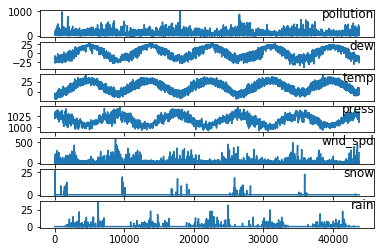

In [150]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot

# load dataset
dataset = pd.read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()

# 3. Multivariate LSTM Forecast Model

## LSTM Data Preparation

LSTM requires data in a specific format, hence the first step is to prepare the pollution dataset for the LSTM.

I will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

For this purpose, I have designed a function to do this iteratively. The fucntions gets the original time series data, how many lag steps to add to features, how many forward steps are to be predicted, and finally if NAN values (created due to shifting of columns for lag variables) must be dropped.

In [111]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Encoding & Scaling of Data

First, the wind speed feature is label encoded (integer encoded), using LabelEncoder from sklearn package. 

Next, all features are normalized, using MinMaxScaler from sklearn package. NOTE: Neural Network deep learning models have found to perform better with Normalisation (MinMaxScaling) rather than Standardisation (StandardSclare).

Finally, I used the function above to transform the dataset into a supervised learning problem. I add the data from the last 24 hours as lag varibales. The weather variables for the hour to be predicted (t) are then removed.

In [114]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 24
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43776, 200)


## Prepare Train & Test Data

First, I split the dataset into train and test sets, then splits the train and test sets into input and output variables. I use 4 years of hsitory data for training and 1 year for testing.

Finally, I reshape the inputs (X) into the 3D format expected by LSTMs (from Keras library), namely (#samples, #timesteps, #features).

In [117]:
# split into train and test sets
values = reframed.values
n_train_hours = 4 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 192) 35040 (35040,)
(35040, 24, 8) (35040,) (8736, 24, 8) (8736,)


## Model Training

In the model below, I design a neural network with three hidden layers: 120 nodes in the first layer, 160 nodes in the second layer and 120 nodes in the third layer.

I also use Mean Absolute Error (mae) as loss function and Adam stochastic optimiser. I run the fitting process for 50 epochs with batch size 72. 

Train on 35040 samples, validate on 8736 samples
Epoch 1/50
35040/35040 - 70s - loss: 0.0388 - val_loss: 0.0453
Epoch 2/50
35040/35040 - 62s - loss: 0.0190 - val_loss: 0.0183
Epoch 3/50
35040/35040 - 62s - loss: 0.0145 - val_loss: 0.0160
Epoch 4/50
35040/35040 - 61s - loss: 0.0145 - val_loss: 0.0151
Epoch 5/50
35040/35040 - 95s - loss: 0.0142 - val_loss: 0.0148
Epoch 6/50
35040/35040 - 75s - loss: 0.0150 - val_loss: 0.0129
Epoch 7/50
35040/35040 - 79s - loss: 0.0142 - val_loss: 0.0133
Epoch 8/50
35040/35040 - 76s - loss: 0.0141 - val_loss: 0.0134
Epoch 9/50
35040/35040 - 69s - loss: 0.0141 - val_loss: 0.0135
Epoch 10/50
35040/35040 - 70s - loss: 0.0142 - val_loss: 0.0138
Epoch 11/50
35040/35040 - 63s - loss: 0.0142 - val_loss: 0.0133
Epoch 12/50
35040/35040 - 63s - loss: 0.0143 - val_loss: 0.0135
Epoch 13/50
35040/35040 - 64s - loss: 0.0141 - val_loss: 0.0137
Epoch 14/50
35040/35040 - 71s - loss: 0.0139 - val_loss: 0.0131
Epoch 15/50
35040/35040 - 66s - loss: 0.0139 - val_loss: 0.0135


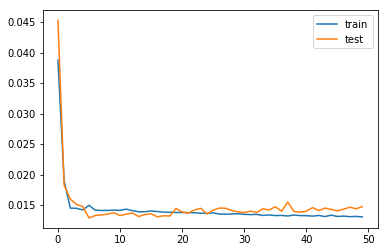

In [120]:
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras import backend
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(units = 120, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units = 160, return_sequences = True))
model.add(LSTM(units = 120))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
fitted_model = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(fitted_model.history['loss'], label='train')
pyplot.plot(fitted_model.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Evaluatation

After the model is fit, I use it to forecast for the entire test dataset.

I then combine the forecast with the test dataset and invert the scaling. I also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, I can then calculate an error score for the model. In this case, I calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [155]:
from numpy import concatenate
from math import sqrt

# make a prediction
predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_predictions = concatenate((predictions, test_X[:, -7:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.805
